In [87]:
import pandas as pd

In [107]:
df = pd.read_csv("data/dataset_lyrics_popularity.csv")

In [89]:
df.columns

Index(['source', 'domain', 'chart', 'region', 'country', 'continent', 'date',
       'position', 'title', 'artist', 'url', 'scraped_at', 'city', 'track_id',
       'album', 'energy', 'danceability', 'valence', 'tempo', 'loudness',
       'acousticness', 'instrumentalness', 'speechiness', 'liveness', 'lyrics',
       'happiness_from_lyrics', 'popularity'],
      dtype='object')

In [108]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,train_test_split

kf = KFold(n_splits=3, shuffle=True, random_state=42)

df = df.drop(labels=['country', 'continent', 'position', 'city','track_id'], axis=1)
df_numeric = df.select_dtypes(include=["number"])
df_numeric = df_numeric.drop(["url"], axis=1)

# Drop rows containing ANY NaN
# df_clean = df_numeric.dropna()

# Build X and y
X = df_numeric.drop(columns=["popularity"])
y = df_numeric["popularity"]

mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [109]:
X_train.columns

Index(['energy', 'danceability', 'valence', 'tempo', 'loudness',
       'acousticness', 'instrumentalness', 'speechiness', 'liveness',
       'happiness_from_lyrics'],
      dtype='object')

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])



In [111]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

def remove_univariate_outliers_df(X, y=None, factor=1.5):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - factor * IQR)) | (X > (Q3 + factor * IQR))).any(axis=1)
    return X.loc[mask]

univariate_outlier_removal = FunctionTransformer(
    remove_univariate_outliers_df,
    validate=False,
    feature_names_out="one-to-one"
)



In [112]:
from sklearn.ensemble import IsolationForest

multivariate_outlier_detector = IsolationForest(
    contamination=0.05,
    random_state=42
)


**Lasso and Ridge Univariate and multivariate Outlier**

In [ ]:
from sklearn.linear_model import Lasso, Ridge

lasso_univariate_pipeline = Pipeline([
    # ("outlier_removal", univariate_outlier_removal),
    ("preprocessing", numeric_pipeline),
    ("model", Lasso(alpha=0.1))
])

ridge_univariate_pipeline = Pipeline([
    # ("outlier_removal", univariate_outlier_removal),
    ("preprocessing", numeric_pipeline),
    ("model", Ridge(alpha=1.0))
])

lasso_multivariate_pipeline = Pipeline([
    ("preprocessing", numeric_pipeline),
    ("model", Lasso(alpha=0.1))
])

ridge_multivariate_pipeline = Pipeline([
    ("preprocessing", numeric_pipeline),
    ("model", Ridge(alpha=1.0))
])


**Gboost Univariate and multivariate outliers**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gboost_univariate_pipeline = Pipeline([
    # ("outlier_removal", univariate_outlier_removal),
    ("preprocessing", numeric_pipeline),
    ("model", GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    ))
])

gboost_multivariate_pipeline = Pipeline([
    ("preprocessing", numeric_pipeline),
    ("model", GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    ))
])


**Training**

In [118]:
pipelines = {
    "lasso_uni": lasso_univariate_pipeline,
    "lasso_multi": lasso_multivariate_pipeline,
    "ridge_uni": ridge_univariate_pipeline,
    "ridge_multi": ridge_multivariate_pipeline,
    "gboost_uni": gboost_univariate_pipeline,
    "gboost_multi": gboost_multivariate_pipeline,
}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f"{name} OK")

lasso_uni OK


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'IsolationForest(contamination=0.05, random_state=42)' (type <class 'sklearn.ensemble._iforest.IsolationForest'>) doesn't

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2_training = r2_score(y_train, pipe.predict(X_train))
    r2 = r2_score(y_test, y_pred)
    cvs = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")

    print(f"{name} results:")
    print(f"R² training: {r2_training:.4f}")
    print(f"R² test: {r2:.4f}")
    print(f"MSE test: {mse}")
    print(f"CVS (neg MSE): {cvs}")
    print("-----")

lasso_uni results:
R² training: 0.0324
R² test: -0.0023
MSE test: 202.07614558850983
CVS (neg MSE): [-249.23587626 -221.17540658 -208.53495364]
-----
lasso_multi results:
R² training: 0.0324
R² test: -0.0023
MSE test: 202.07614558850983
CVS (neg MSE): [-249.23587626 -221.17540658 -208.53495364]
-----
ridge_uni results:
R² training: 0.0330
R² test: -0.0080
MSE test: 203.2324210473777
CVS (neg MSE): [-250.00529689 -221.69784154 -211.79357161]
-----
ridge_multi results:
R² training: 0.0330
R² test: -0.0080
MSE test: 203.2324210473777
CVS (neg MSE): [-250.00529689 -221.69784154 -211.79357161]
-----
gboost_uni results:
R² training: 0.5119
R² test: 0.2325
MSE test: 154.75322584688425
CVS (neg MSE): [-232.54493442 -207.63166346 -195.05728017]
-----
gboost_multi results:
R² training: 0.5119
R² test: 0.2325
MSE test: 154.75322584688425
CVS (neg MSE): [-232.54493442 -207.63166346 -195.05728017]
-----


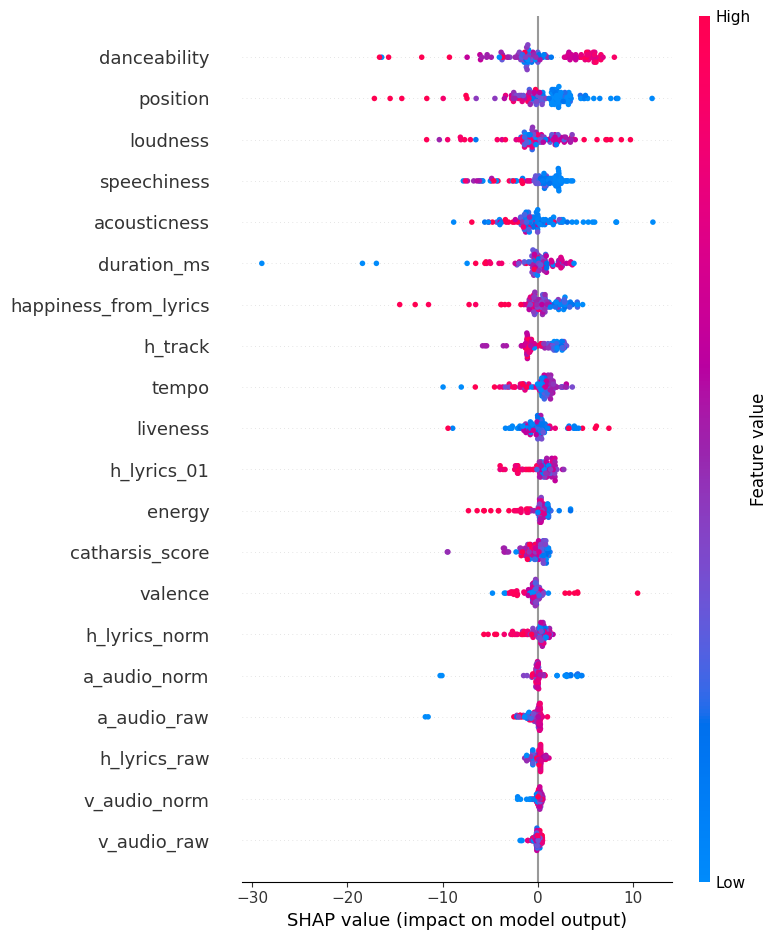

In [ ]:
import shap

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


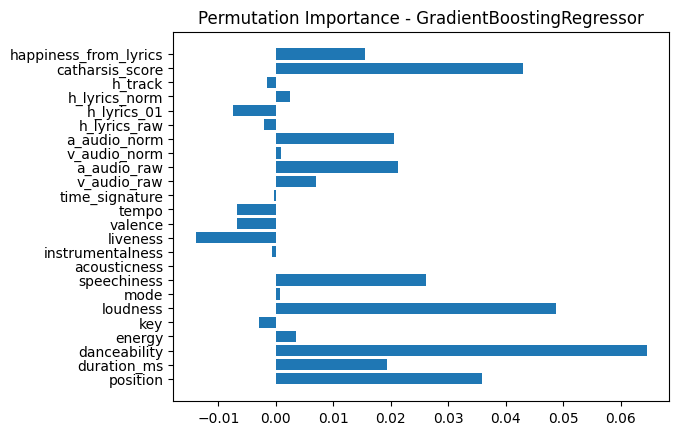

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

perm = permutation_importance(reg, X_test, y_test, n_repeats=20, random_state=42)

plt.barh(X_test.columns, perm.importances_mean)
plt.title("Permutation Importance - GradientBoostingRegressor")
plt.show()

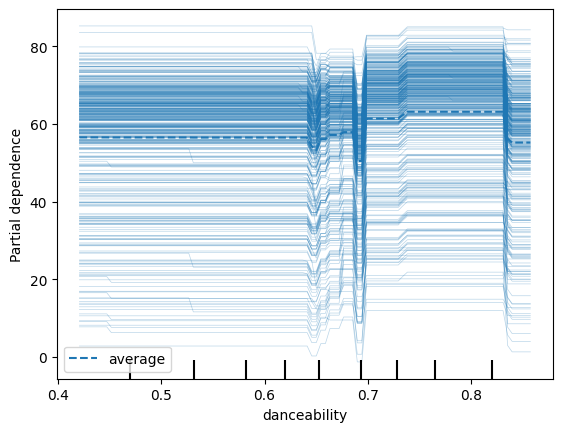

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features = ["danceability"]  # indices des variables OU noms si DataFrame

PartialDependenceDisplay.from_estimator(
    reg, X_train, features, kind="both"
)
plt.show()

In [ ]:
shap.initjs()

i = 13  # index du sample
print(y_test.iloc[i])

shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test.iloc[i] if hasattr(X_test, "iloc") else X_test[i]
)


80


In [ ]:
from sklearn.ensemble import IsolationForest
import pandas as pd

iso = IsolationForest(
    contamination=0.03,  # try 1–5% depending on dataset size
    random_state=42
)

outlier_flag = iso.fit_predict(X)  # X = your feature matrix
X_clean = X[outlier_flag == 1]
y_clean = y[outlier_flag == 1]
print(f"Removed {sum(outlier_flag == -1)} outliers")

Removed 17 outliers


In [ ]:
# Select the outliers
X_outliers = X[outlier_flag == -1]
y_outliers = y[outlier_flag == -1]

# See the first few outliers
print(X_outliers.head())
print(y_outliers.head())

# Or check how many
print(f"Number of outliers: {len(X_outliers)}")


     position  duration_ms  danceability  energy  key  loudness  mode  \
31         35       245425         0.704   0.225    6   -14.454     0   
85         26       173333         0.726   0.431    8    -8.765     0   
198        51       374453         0.554   0.949    2    -4.928     1   
216        85       254805         0.448   0.826    2    -3.244     0   
227        96       314760         0.823   0.743    0   -13.980     1   

     speechiness  acousticness  instrumentalness  ...  v_audio_raw  \
31        0.0994      0.902000            0.6570  ...    -1.225225   
85        0.1350      0.731000            0.0000  ...    -0.852804   
198       0.0787      0.000318            0.0001  ...    -0.860694   
216       0.0319      0.007560            0.0000  ...    -1.413209   
227       0.0316      0.005590            0.0306  ...     1.739163   

     a_audio_raw  v_audio_norm  a_audio_norm  h_lyrics_raw  h_lyrics_01  \
31     -0.726011      0.227018      0.326071      5.594048     0.

In [ ]:
outliers_df = pd.concat([X_outliers, y_outliers.rename("target")], axis=1)
print(outliers_df.head())


     position  duration_ms  danceability  energy  key  loudness  mode  \
31         35       245425         0.704   0.225    6   -14.454     0   
85         26       173333         0.726   0.431    8    -8.765     0   
198        51       374453         0.554   0.949    2    -4.928     1   
216        85       254805         0.448   0.826    2    -3.244     0   
227        96       314760         0.823   0.743    0   -13.980     1   

     speechiness  acousticness  instrumentalness  ...  a_audio_raw  \
31        0.0994      0.902000            0.6570  ...    -0.726011   
85        0.1350      0.731000            0.0000  ...     0.015061   
198       0.0787      0.000318            0.0001  ...     0.441028   
216       0.0319      0.007560            0.0000  ...    -0.684482   
227       0.0316      0.005590            0.0306  ...     0.589337   

     v_audio_norm  a_audio_norm  h_lyrics_raw  h_lyrics_01  h_lyrics_norm  \
31       0.227018      0.326071      5.594048     0.574256     

<Axes: xlabel='acousticness'>

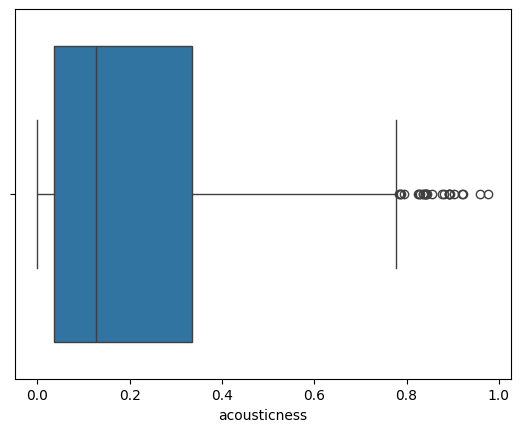

In [ ]:
import seaborn as sns
sns.boxplot(x=df['acousticness'])

In [ ]:

feature = "acousticness"
Q1 = X[feature].quantile(0.25)
Q3 = X[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X[(X[feature] < lower_bound) | (X[feature] > upper_bound)]

,position,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,v_audio_raw,a_audio_raw,v_audio_norm,a_audio_norm,h_lyrics_raw,h_lyrics_01,h_lyrics_norm,h_track,catharsis_score,happiness_from_lyrics
4,8,233456,0.440,0.317,8,-9.258,1,0.0531,0.891,0.000005,...,-0.736553,-0.610153,0.323758,0.352024,6.264151,0.658019,0.631414,0.508352,0.173072,0.521973
31,35,245425,0.704,0.225,6,-14.454,0,0.0994,0.902,0.657000,...,-1.225225,-0.726011,0.227018,0.326071,5.594048,0.574256,0.284800,0.261687,0.240742,0.436007
38,3,269560,0.422,0.264,8,-7.064,1,0.0322,0.922,0.000000,...,-0.513101,-1.346831,0.374467,0.206389,6.221497,0.652687,0.609549,0.515516,0.099992,0.836775
45,36,189486,0.775,0.327,11,-7.241,1,0.0557,0.841,0.000000,...,0.423273,-0.691399,0.604266,0.333722,5.968281,0.621035,0.473542,0.525832,0.158240,0.676157
51,68,169265,0.667,0.373,4,-9.389,1,0.0500,0.785,0.000000,...,-1.395207,-0.478352,0.198578,0.382641,5.694488,0.586811,0.331351,0.278242,0.276175,0.290156
55,11,233720,0.609,0.378,4,-9.828,1,0.4380,0.835,0.000000,...,0.139524,-0.891064,0.534824,0.290890,6.176347,0.647043,0.585916,0.565479,0.126398,0.520542
115,18,285240,0.556,0.319,9,-8.251,1,0.0281,0.893,0.000000,...,-0.644335,-0.728469,0.344267,0.325531,5.673846,0.584231,0.321470,0.330589,0.217914,0.438745
209,22,193320,0.500,0.225,0,-10.220,1,0.0302,0.842,0.000000,...,-0.427976,-0.596832,0.394610,0.355069,6.111148,0.638893,0.551107,0.488508,0.181615,0.205110
247,2,250106,0.450,0.311,4,-8.175,1,0.0314,0.977,0.007130,...,-0.385413,-1.118201,0.404822,0.246345,5.941181,0.617648,0.458859,0.437244,0.138632,0.911911
278,7,115240,0.484,0.332,1,-10.312,1,0.0370,0.787,0.000000,...,0.735398,-0.882993,0.675989,0.292558,6.096154,0.637019,0.543018,0.596206,0.118133,0.604787


In [ ]:
count = (df["position"] == -1).sum()
print(count)


173
